Import des librairies :

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.impute import KNNImputer
import numpy as np
from minisom import MiniSom

Chargement des données :

In [113]:
df = pd.read_csv('diabetes.xls')
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


Vérification de l'équilibrage du jeu de données :

In [114]:
df["Outcome"].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

Nous avons dans notre dataset 500 personnes ne présentant pas de diabète contre 268 personnes étant diabétiques, nous allons alors sous-échantillonner notre classe contenant le plus d'invididu.

In [115]:
positive_diabetes = df[df["Outcome"]==1]
negative_diabetes = df[df["Outcome"]==0]

negative_downsampled = resample(negative_diabetes,
                                replace=True,
                                n_samples=len(positive_diabetes))

df = pd.concat([negative_downsampled, positive_diabetes])
df["Outcome"].value_counts()

Outcome
0    268
1    268
Name: count, dtype: int64

Analyse univariée des variables :

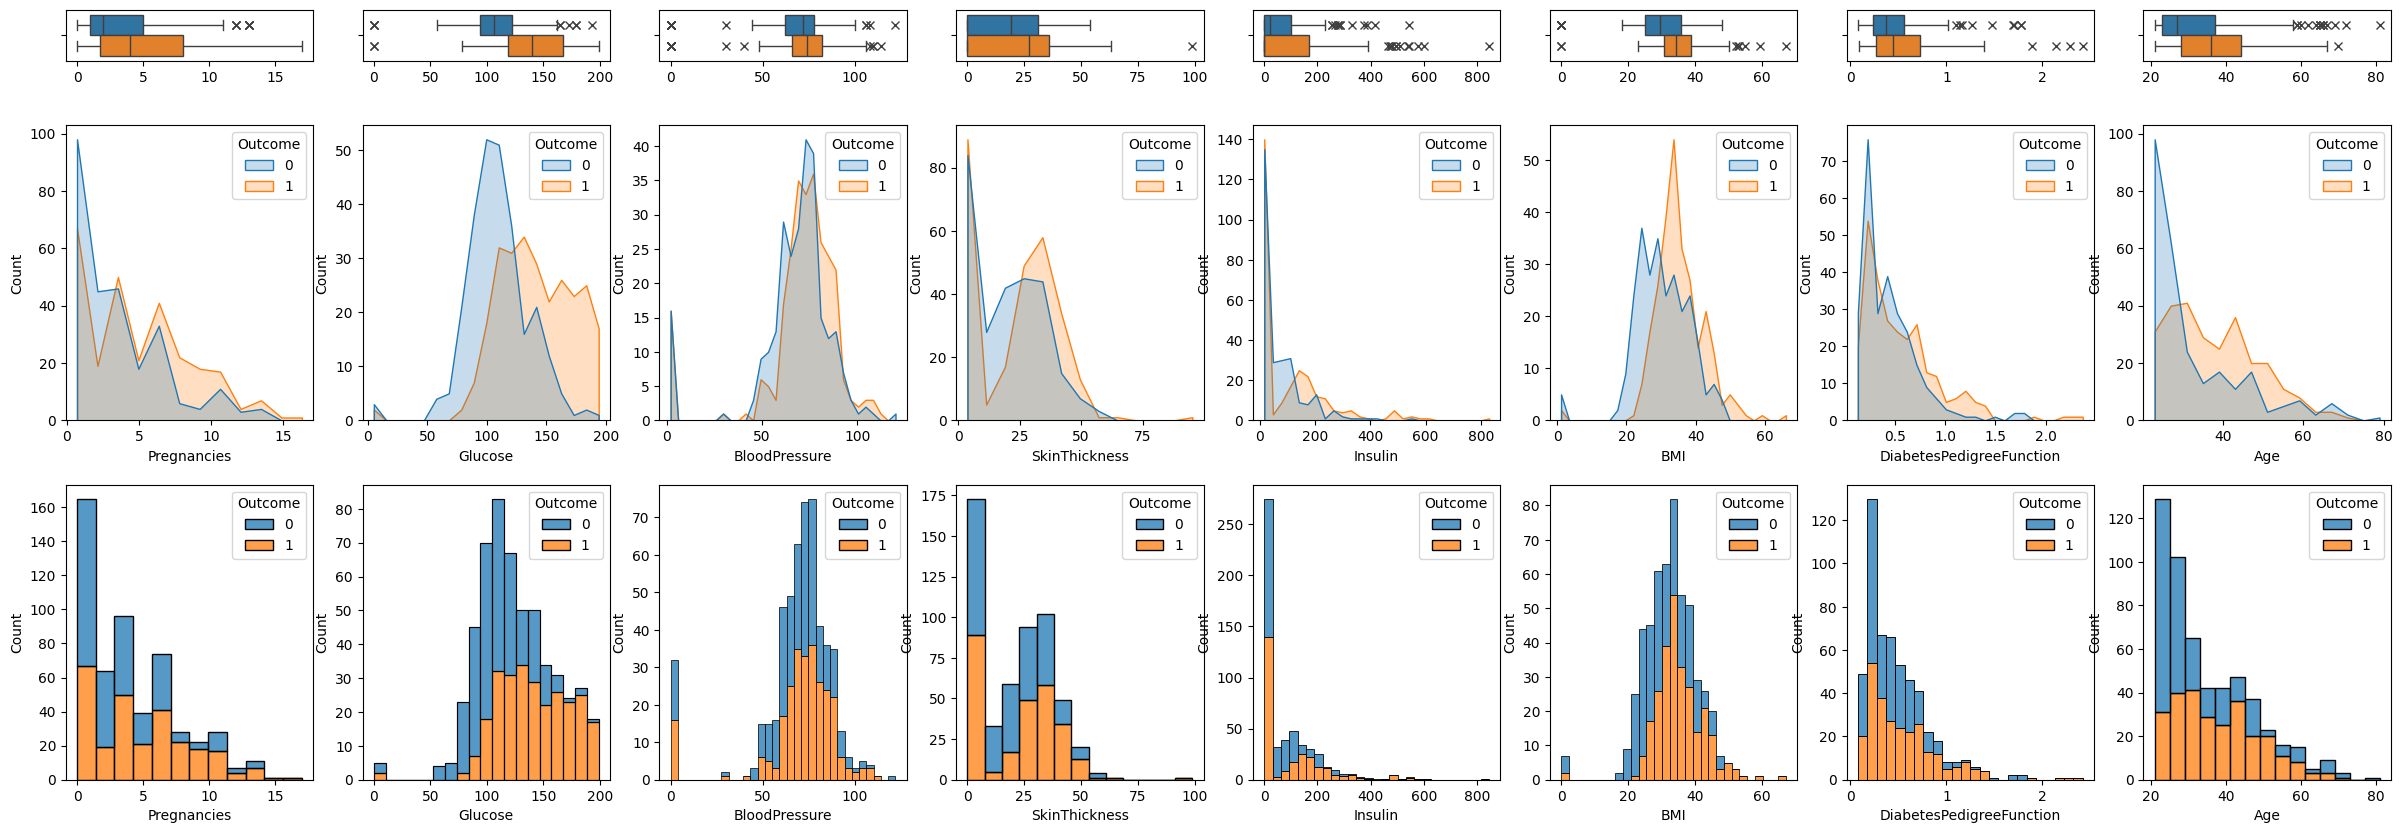

In [116]:
# List of features
features = (df.columns).drop("Outcome")

# Number of features
num_features = len(features)

# Create a grid of subplots
fig = plt.figure(figsize=(30, 10))
gs = GridSpec(3, num_features, height_ratios=[0.08, 0.46, 0.46], hspace=0.3)

for i, feature in enumerate(features):
    # Subplot for the boxplot
    ax_box = fig.add_subplot(gs[0, i])

    # Subplots for the distributions plots
    ax_hist_1 = fig.add_subplot(gs[1, i])
    ax_hist_2 = fig.add_subplot(gs[2, i])

    # Plot the boxplot
    sns.boxplot(data=df, x=feature, hue="Outcome", orient="h", ax=ax_box, flierprops={"marker": "x"}).legend([],[], frameon=False) 

    # Plot the distribution plot
    sns.histplot(data=df, x=feature, hue="Outcome", ax=ax_hist_1, element="poly")

    # Plot the distribution plot
    sns.histplot(data=df, x=feature, hue="Outcome", ax=ax_hist_2, multiple="stack")

    # Remove x-axis label for the boxplot
    ax_box.set(xlabel='')

# Show the plots
plt.show()

Nous voyons certains points très intéressant sur les distributions, décortiquons les variables une par une :

* Pour le nombre de fois que la personne est tombée enceinte :
    - les distributions se superposent, on notera qu'en moyenne, un nombre élevé de grossesse est légérement corrélé avec le fait de présenter un diabete, cependant, au vu du nombre d'échantillons dans le dataset ainsi que de la nature de la variable. On ne peut pas en déduire grand chose. De plus, les distributions sont similaires aux distributions sur l'age des individus : une femme qui est plus agé, a eu plus de temps dans sa vie pour potentiellement tombé enceinte plus de fois, et, cela est également corrélé au fait d'avoir plus de chance de présenter un diabète, selon le ministère de la santé "le diabete apparait généralement apres 40 ans, sa fréquence augmente avec l'age". la  corrélation de la variable "nombre de grossesse" est donc une conséquence de sa correlation avec la varible "age", qui elle explique très nettement son rapport avec la maladie.

    <br>

* Pour le glucose dans le sang obtenu pendant 2h de test à la tolérance au glucose :
    - On remarque qu'en moyenne, les diabétiques présentes une concentration plus élevée de glucose dans le sang que les non diabétiques, on pourrait croire à une distribution bimodale pour les diabétique (peut etre expliqué par des différents types de diabètes ou des variations dans l'expression de la maladie) cependant c'est une conjoncture à prendre avec précaution au vue de la taille réduite de l'échantillon. La corrélation entre le taux de glucose et la présentation d'un diabète est tout à fait logique, d'apres la fédération française des diabétiques "le diabète est un trouble de l'assimilation [...] des sucres apportés par l'alimentation, cela se traduit par un taux de glucose dans le sang élevé".  

    <br>

* Pour la pression sanguine :
    - Les distributions se ressemblent, cependant la courbe des personnes présentant un diabète est légérement décalé vers des pressions sanguines supérieures que celle des personnes saines. D'après la fédération française des diabétiques, l'hypertension artérielle et le diabète sont "une association fréquente", ce qui pourrait expliquer cette légère différence observée. On note 35 individus dont la pression sanguine est anormalement basse (d'apres WHO, la pression artérielle moyenne est de 80 mm Hg). Cette différence anormalement élevée peut peut etre s'expliquer par une défaillance d'un capteur par exemple. 

    <br> 

* Pour l'épaisseur de peau au niveau du triceps :
    - les distributions se superposent, elles parraissent normales avec une forte population ayant 0 comme valeur d'épaisseur de peau (en mm), ce qui n'est naturellement pas possible, et qui devra etre traiter de la meme facon que les données manquantes pour la variable "pression sanguine".  

    <br>

* Pour le taux d'insuline dans le sang :
    - Encore une fois, les distributions semblent normales et se superposent, avec encore une fois un grand nombre de valeur à 0, cependant, il manque d'informations précises sur les données, car ici le taux d'insuline est en mu U/ml, et non en g/L comme habituellement présenté.  

    <br>

* Pour l'indice de masse corporelle :
    - Les distributions sont les memes mais décalée vers les indices élevés pour les patients présentant un diabète, ce qui est totalement logique, encore d'apres la fédération française des diabétiques "l'apparition du diabète est favorisé par un indice de masse corporelle important".  Les deux distributions sont normales.

    <br>

* Pour la DiabetePedigreeFunction, qui représente la possibilité d'avoir un diabète d'après l'historique familial :
    - Les distributions sont assez similaires, on remarque que lorsque la valeur dépasse les 1, on a quasiment 100% de chance de présenter un diabète.  

    <br>

* Pour l'age :
    - comme expliqué précédement dans l'analyse du nombre de grosesse, l'age est un facteur aggravant pour la présentation d'un diabète.

    



Analyse bivariée des variables :


voici la matrice de corrélation entre les variables

In [117]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.122425,0.114777,-0.021998,-0.076681,-0.023369,-0.061675,0.508352,0.216798
Glucose,0.122425,1.000000,0.134433,0.093468,0.329583,0.213425,0.116488,0.258182,0.488392
BloodPressure,0.114777,0.134433,1.000000,0.247712,0.094395,0.264853,0.060583,0.265785,0.087984
SkinThickness,-0.021998,0.093468,0.247712,1.000000,0.446767,0.360419,0.206469,-0.063072,0.109502
Insulin,-0.076681,0.329583,0.094395,0.446767,1.000000,0.144789,0.154495,-0.021155,0.166232
BMI,-0.023369,0.213425,0.264853,0.360419,0.144789,1.000000,0.177250,0.005305,0.315124
DiabetesPedigreeFunction,-0.061675,0.116488,0.060583,0.206469,0.154495,0.177250,1.000000,0.014495,0.174965
Age,0.508352,0.258182,0.265785,-0.063072,-0.021155,0.005305,0.014495,1.000000,0.234988
Outcome,0.216798,0.488392,0.087984,0.109502,0.166232,0.315124,0.174965,0.234988,1.000000


<Axes: >

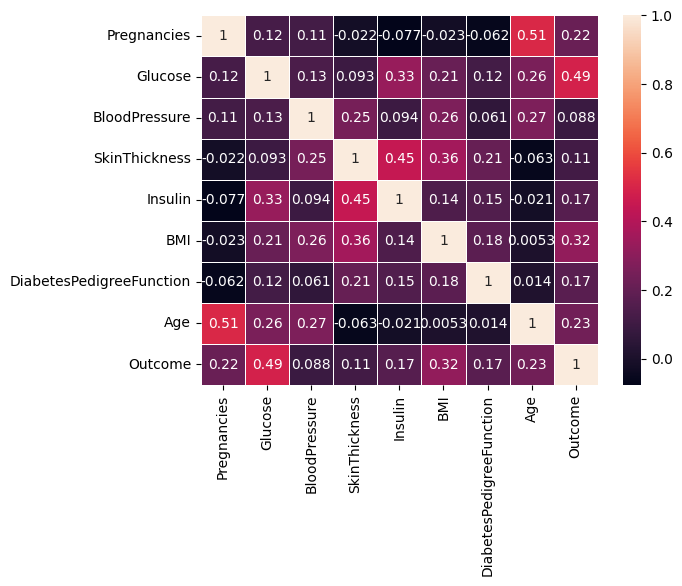

In [118]:
sns.heatmap(df.corr(), annot=True, linewidths=.5) 

Sur cette matrice de corrélation, de nombreux points sont intéressants :

-   Premier point, comme conjoncturé lors de l'analyse univariée plus haut, les variables 'Age' et 'Pregnancies' sont fortement corrélées.

-   Deuxieme point, les variables 'Insulin' et 'SkinThickness' sont assez corrélées, en cherchant sur internet, je n'ai pas trouvé d'explication à ce phénomène.

-   Troisième point, les variables 'BMI' et 'SkinThickness' sont également légérement corrélées, d'après la 'National Library of Medicine' Americaine, 'The skin thickness increases with increase in BMI for arm, thigh and abdomen regions in both the genders'. Dans notre dataset, il est expliqué que l'épaisseur de peau à été mesurée au niveau des tricEps des patients, ce qui est inclu dans les zones du corps ayant une épaisseur de peau augmentant avec un fort BMI. La corrélation observée est donc naturelle.

-   Quatrième point, l'Outcome est corrélée majoritairement avec 4 variables étant le 'Glucose', le 'BMI' ainsi que les variables 'Age' et 'Pregnancies'. Les données médicales citées durant l'analyse univariée des variables valident la causalité de ces valeurs à déclarer un diabète.

Passons maintenant à l'application des Self-Organizing-Maps sur notre jeu de données :

Commençons par remplacer les valeurs manquantes de notre dataset

In [119]:
cols_to_impute = ['BloodPressure', 'SkinThickness', 'BMI']
imputer = KNNImputer(n_neighbors=5)
df[cols_to_impute] = df[cols_to_impute].replace(0, float('nan'))
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

Maintenant, séparons nos données en un jeu d'entrainement et un jeu de test, puis normalisons les.

In [120]:
X = (df.drop('Outcome', axis=1)).to_numpy()
y = df['Outcome'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Implémentons maintenant la self-organizing-map :

In [121]:
def classify(som, data):
    winmap = som.labels_map(X_train, y_train)
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [122]:
som = MiniSom(7, 7, len(features), sigma=3, learning_rate=0.5, 
              neighborhood_function='triangle')

som.train_random(X_train, 1000, verbose=False)

y_pred = classify(som, X_test)
confusion_matrix(y_test, y_pred)

array([[46,  9],
       [17, 36]])

In [123]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.84      0.78        55
           1       0.80      0.68      0.73        53

    accuracy                           0.76       108
   macro avg       0.77      0.76      0.76       108
weighted avg       0.76      0.76      0.76       108



On voit que le modèle arrive plutot correctement à classifier les patients, qu'ils présentent un diabétique ou non. Que les individus présentent un diabète ou non, le modèle classifie avec une bonne performance (voir la confusion matrix), ce qui valide les publications scientifiques expliquant les causes du diabètes parmis les facteurs suivants : BMI, Age, Taux de glucose...